In [98]:
#Trigger-Setting ofdmfft|source_sop either edge
import numpy as np  
import matplotlib.pyplot as plt
from signaldump import signaltapCsvDumper
import seaborn
plt.rcParams['figure.figsize']=[10,10]
import csv
import CommonScript as cs
import matplotlib.animation as animation
from bitstring import BitArray
signalTapCsvPath = 'C:\\spec\\all07.csv'

0x61616161616161616161616161616161


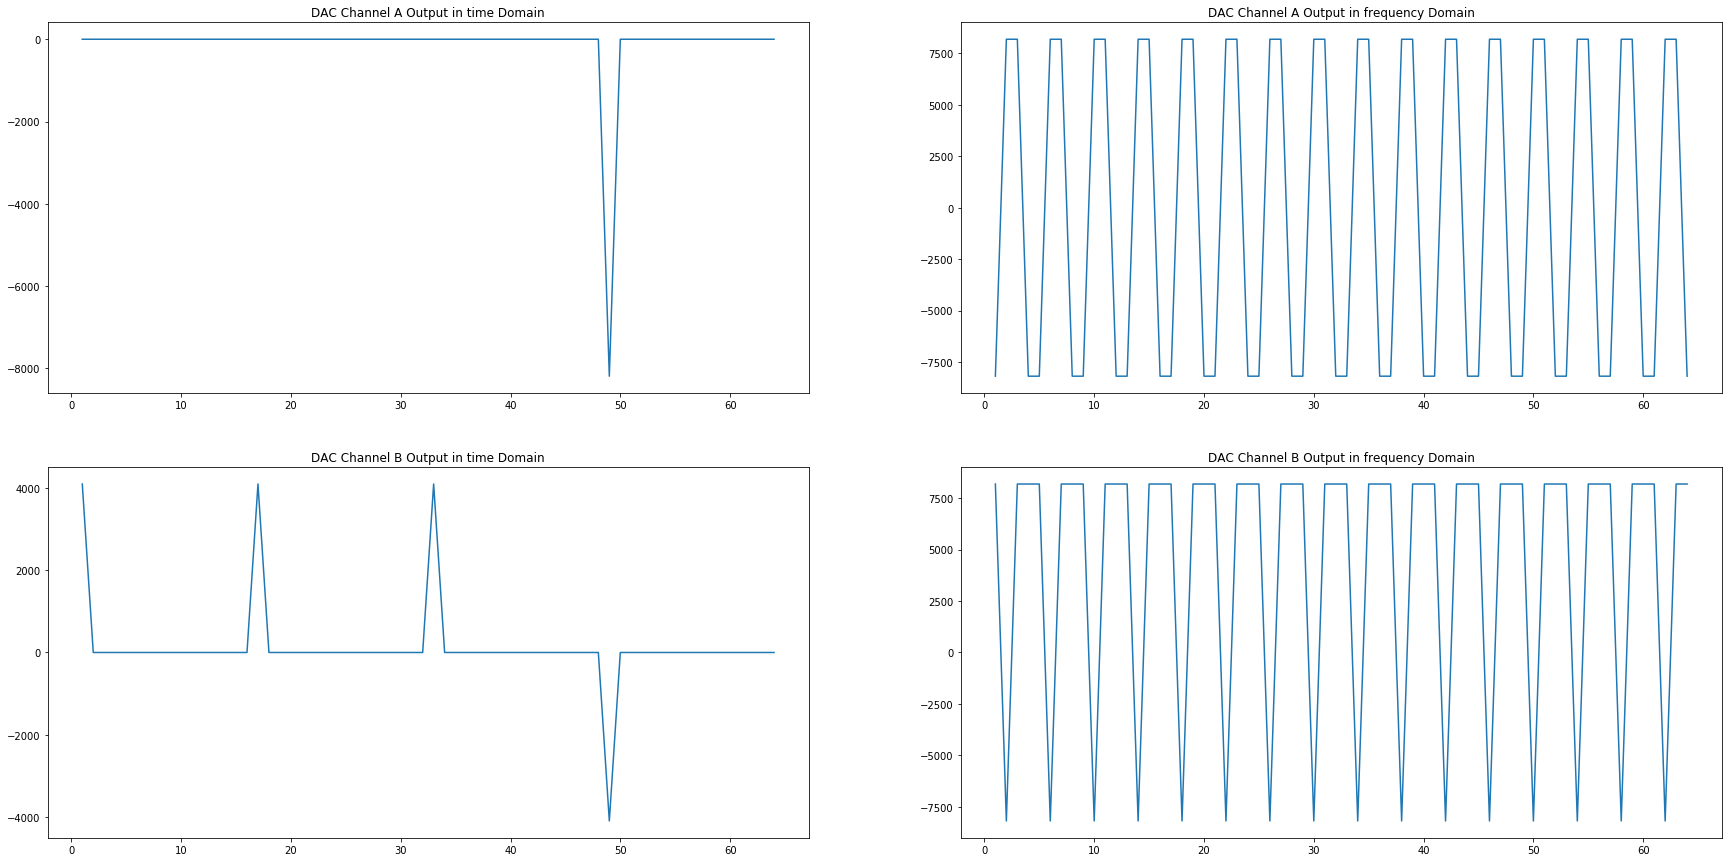

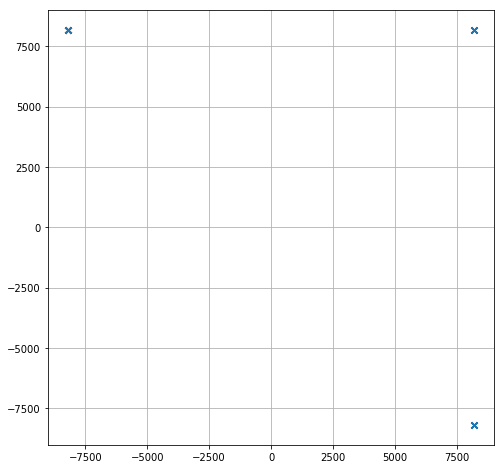

In [99]:
dumper=signaltapCsvDumper(signalTapCsvPath)
dumper.dumpSession(signalPattern=["DA\[(\d+)\]","DB\[(\d+)\]"],condition="active-high",validPattern=["ofdmdaccontrol|asi_in0_valid"],outputName="TransiverDAOutput",unsigned=True)
with open('./TransiverDAOutput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    real = np.array(csvBuffer[0],dtype=int)[::20]-8192
    imag = np.array(csvBuffer[1],dtype=int)[::20]-8192
    outSignal = real + imag*1j
    frequencyDomain=np.fft.fft(outSignal)
    plt.plot(lengthVector,real,'-')
    plt.title('DAC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('DAC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('DAC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-')

    plt.title('DAC Channel B Output in frequency Domain')

fftResult  = frequencyDomain
demodReal=np.real(fftResult)
demodImag=np.imag(fftResult)

plt.figure(figsize=(8,8))
plt.grid(True,axis='both',which='major')
plt.scatter(demodReal,demodImag,marker='x')

demodOut = cs.ConstellationDeMapping(demodReal,demodImag)

print(hex(int(demodOut,2)))
sendData = int(demodOut,2)


[215 199 199 194 194 193 195 198 188 193 198 195 196 195 194 187 189 196
 185 191 181 185 185 188 189 182 185 185 180 179 182 184 178 178 178 178
 184 176 178 178 178 175 179 177 174 173 170 174 173 176 169 170 169 172
 169 167 166 166 173 171 169 165 169 169]
[53 48 45 51 49 47 49 50 49 52 55 50 50 52 49 52 51 60 49 51 54 51 55 59
 62 54 56 56 60 60 55 61 63 56 57 52 57 61 66 60 61 61 69 61 69 61 67 67
 60 64 62 67 64 68 64 72 62 66 67 62 69 68 64 71]
0x3fefeeb324a6e282a8eaa00a02080000
39.682539682539684


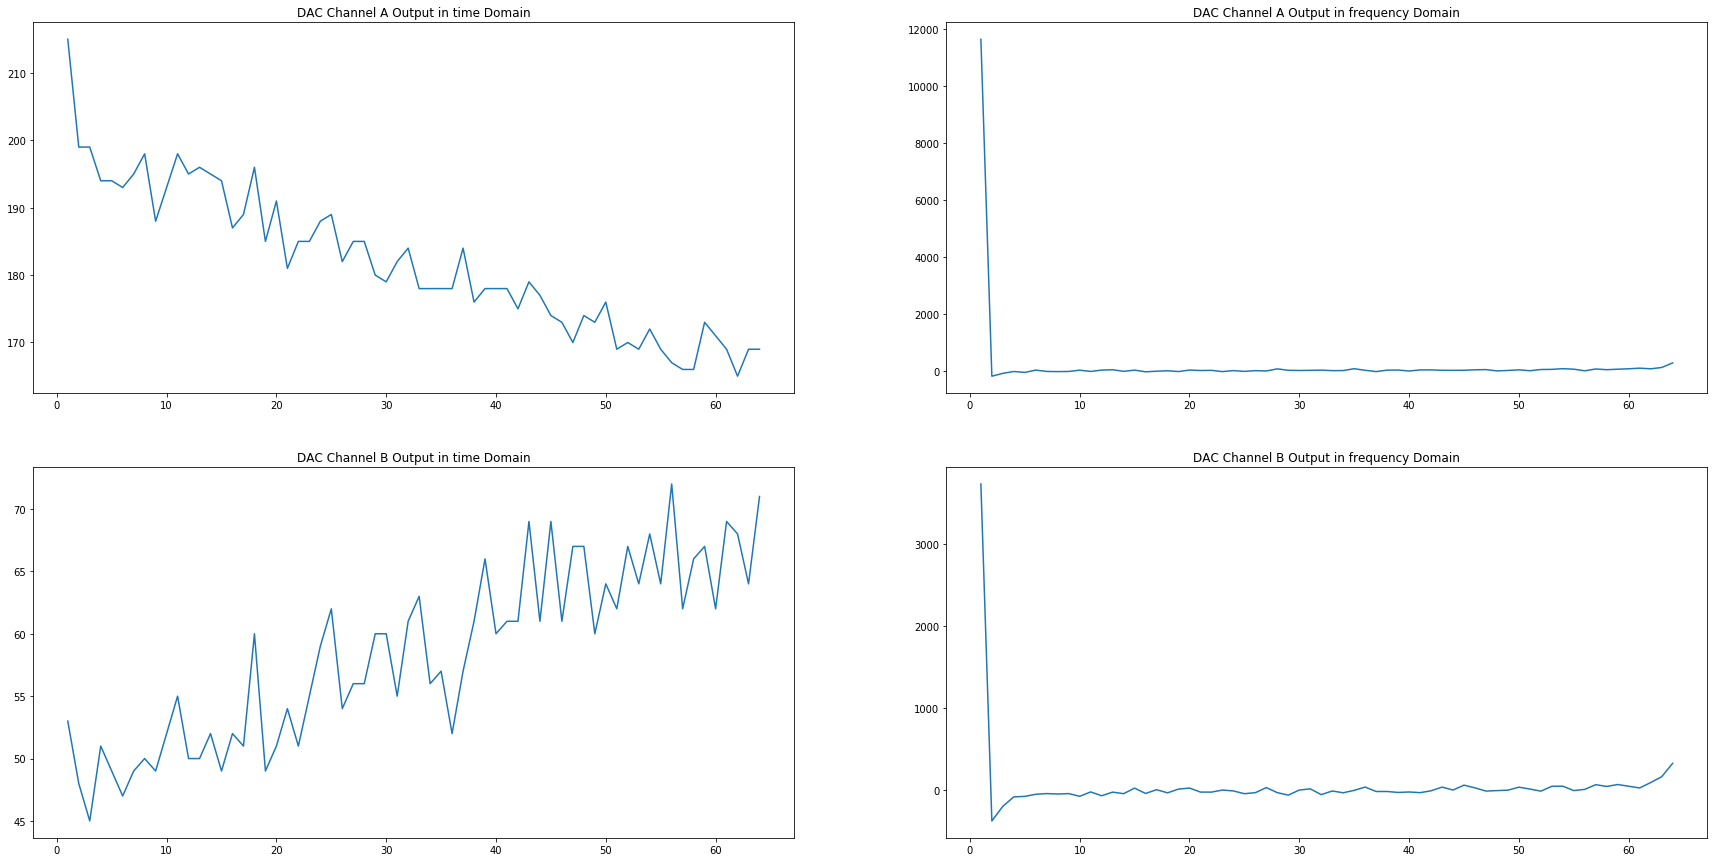

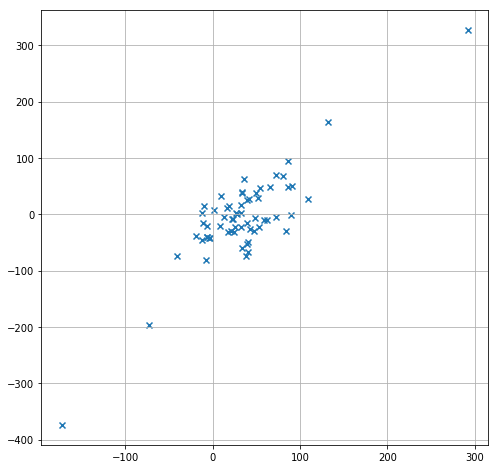

In [100]:
def symbolSync(series):
    accu_flag=0
    ma1=0
    ma2=0
    ma1_accu=0
    ma2_accu=0
    v2=0
    v1=0
    th=100
    for v,i in enumerate(real):
        ma1_accu=ma1_accu+i
        ma2_accu=ma2_accu+i
        if(v2==3):
            ma2=ma2_accu//4
#             print(ma2,ma2-ma1)
            if(accu_flag):
                if(abs(ma1-ma2)>th):
                    return v+35
            v2=0
            ma2_accu=0
        else:
            v2=v2+1
        if(v1==31):
            accu_flag=1
            ma1=ma1_accu//32
            v1=0
            ma1_accu=0
        else:
            v1=v1+1
dumper=signaltapCsvDumper(signalTapCsvPath)
dumper.dumpSession(signalPattern=["ADA_D\[(\d+)\]","ADB_D\[(\d+)\]"],condition="range",inf=0,sup=4000,outputName="ReceiverADInput")

with open('./ReceiverADInput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    real = np.negative(np.array(csvBuffer[0],dtype=int))
    imag = np.negative(np.array(csvBuffer[1],dtype=int))
    reagIndex=symbolSync(real)
    imagIndex=symbolSync(imag)
    real = real[reagIndex:reagIndex+1279:20]
    imag = imag[imagIndex:imagIndex+1279:20]
    print(real)
    print(imag)
    outSignal = real + imag*1j
    frequencyDomain=np.fft.fft(outSignal)
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    plt.plot(lengthVector,real,'-')
    plt.title('DAC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('DAC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('DAC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-')

    plt.title('DAC Channel B Output in frequency Domain')

    fftResult  = frequencyDomain
    demodReal=np.real(fftResult)
    demodImag=np.imag(fftResult)

    plt.figure(figsize=(8,8))
    plt.grid(True,axis='both',which='major')
    plt.scatter(demodReal[1:],demodImag[1:],marker='x')

    demodOut = cs.ConstellationDeMapping(demodReal,demodImag)
    #Calculate BER
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)

    



128
[  193   134   134   131   137   130   134   131   128   137   134   136
   131   131   128   130   130   131   127   131   134   130   130   130
   131   129   129   133   131   130   128   130   124   136   132   128
   132   133   129   127   130   131   131   125   130   132   128   130
 -6338   230   210   203   201   191   192   196   197   194   192   194
   194   192   195   192]
[   54    45    56    58    55    54    54    60    64    61    57    61
    60    58    60    62  3291    18    32    31    34    31    39    34
    34    34    32    33    33    38    36    37  3271    -7    16     7
    14    11    13    12    16    13    13    17    12    17    11    19
 -3216    61    55    53    49    49    46    47    46    49    52    49
    50    52    54    51]
0x21616161616161616161616161616161
46.03174603174603


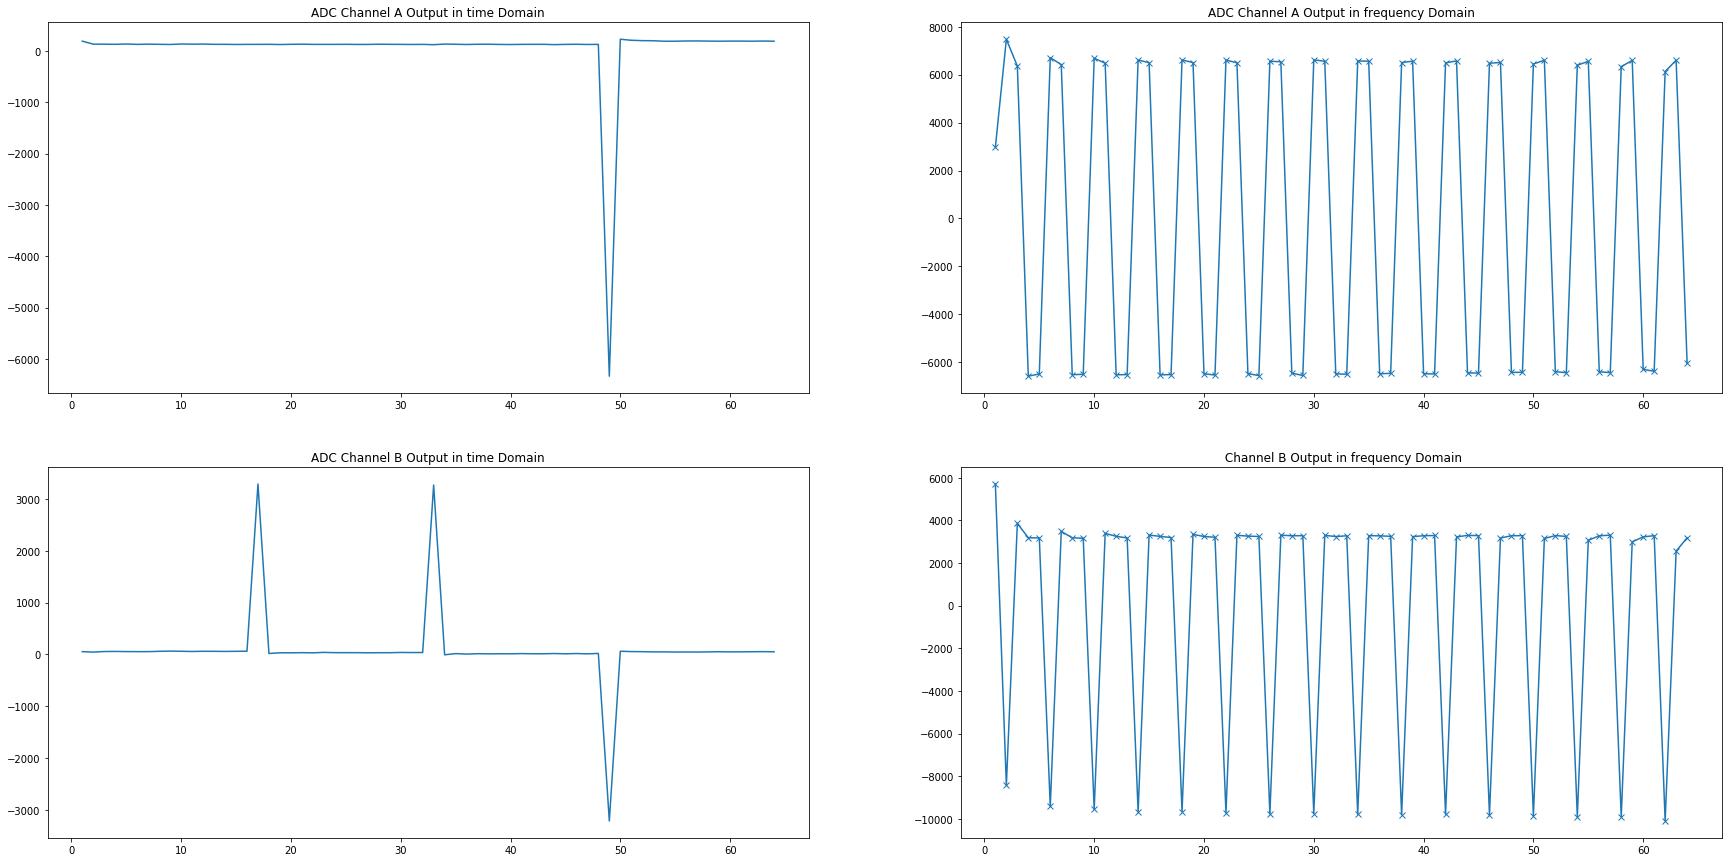

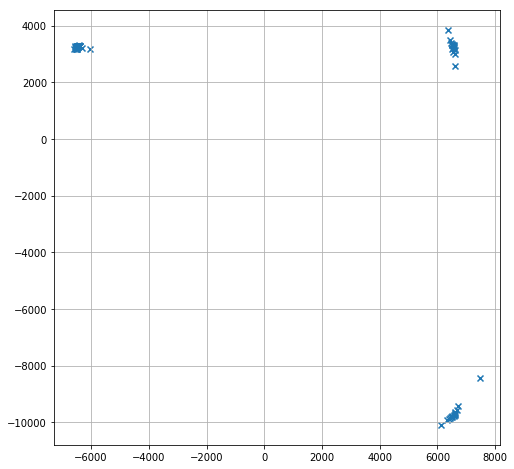

In [101]:
dumper=signaltapCsvDumper(signalTapCsvPath)
dumper.dumpSession(signalPattern=["ofdmsymbolsync\|aso_out0_data\[(\d+)\]"],condition="active-high",validPattern=["ofdmsymbolsync|aso_out0_valid"],outputName="ReceiverSyncOutput")
with open('./ReceiverSyncOutput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    data = np.array(csvBuffer[0],dtype=int)
    data = [np.binary_repr(i,width=32) for i in data]
    real = np.array([BitArray(bin=i[0:16]).int for i in data])
    imag = np.array([BitArray(bin=i[16:]).int for i in data])
    print(real.size)

    real = real[0::2]
    imag = imag[0::2]
    print(real)
    print(imag)
    outSignal = real + imag*1j
    frequencyDomain=np.fft.fft(outSignal)
    #frequencyDomain+=frequencyDomain[0]
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    plt.plot(lengthVector,real,'-')
    plt.title('ADC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('ADC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-x')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('ADC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-x')

    plt.title(' Channel B Output in frequency Domain')

    fftResult  = frequencyDomain
    demodReal=np.real(fftResult)
    demodImag=np.imag(fftResult)

    plt.figure(figsize=(8,8))
    plt.grid(True,axis='both',which='major')
    plt.scatter(demodReal[1:],demodImag[1:],marker='x')

    demodOut = cs.ConstellationDeMapping(demodReal[1:],demodImag[1:])
    #Calculate BER
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)


[  193   134   134   131   137   130   134   131   128   137   134   136
   131   131   128   130   130   131   127   131   134   130   130   130
   131   129   129   133   131   130   128   130   124   136   132   128
   132   133   129   127   130   131   131   125   130   132   128   130
 -6338   230   210   203   201   191   192   196   197   194   192   194
   194   192   195   192]
[   54    45    56    58    55    54    54    60    64    61    57    61
    60    58    60    62  3291    18    32    31    34    31    39    34
    34    34    32    33    33    38    36    37  3271    -7    16     7
    14    11    13    12    16    13    13    17    12    17    11    19
 -3216    61    55    53    49    49    46    47    46    49    52    49
    50    52    54    51]
sendData: 0x61616161616161616161616161616161
sendData: 0x21616161616161616161616161616161
0x21616161616161616161616161616161
46.03174603174603


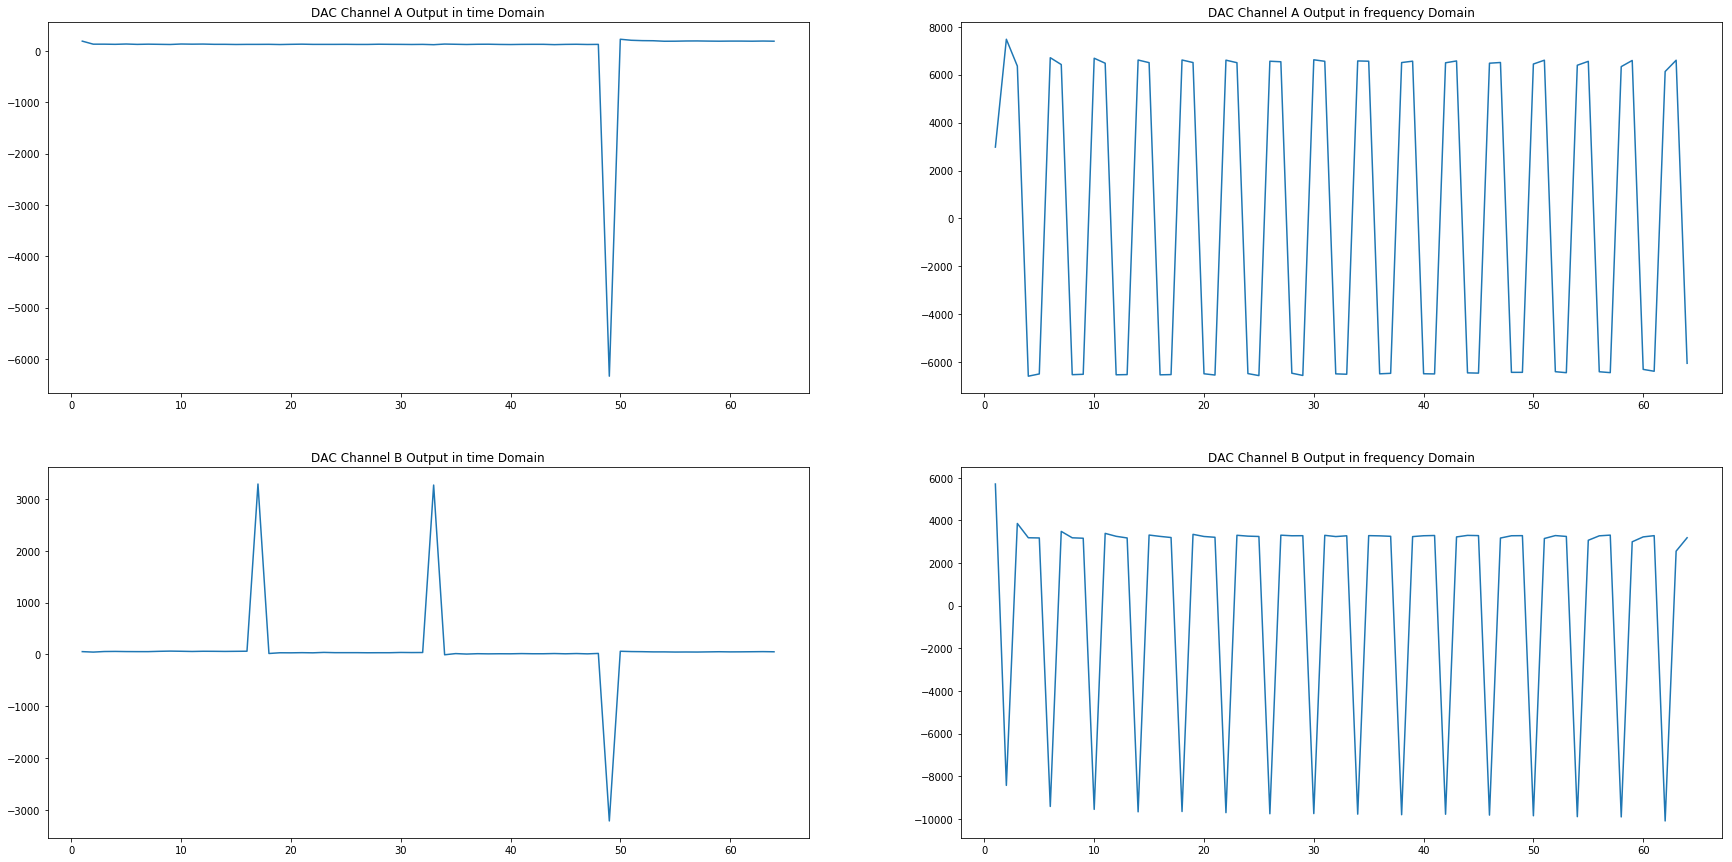

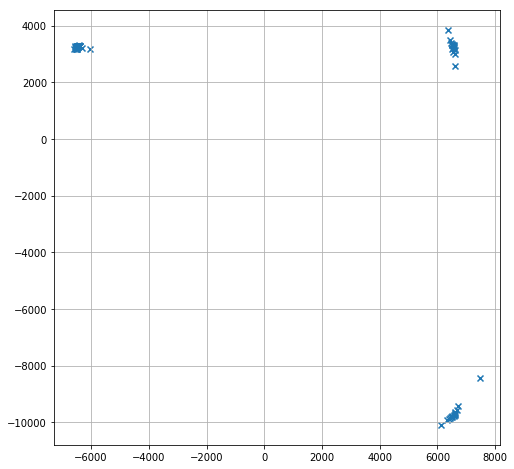

In [102]:
dumper=signaltapCsvDumper(signalTapCsvPath)
dumper.dumpSession(signalPattern=[".*ReceiverTopQsys_0_FFT:fft\|sink_real\[(\d+)\]",".*ReceiverTopQsys_0_FFT:fft\|sink_imag\[(\d+)\]"],condition="active-high",validPattern=["ReceiverTopQsys_0_FFT:fft|sink_valid"],outputName="RXFFTInput")
with open('./RXFFTInput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    data = np.array(csvBuffer,dtype=int)
    real=data[0][::2]
    imag=data[1][::2]

    print(real)
    print(imag)
    outSignal = real + imag*1j
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    plt.plot(lengthVector,real,'-')
    plt.title('DAC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('DAC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('DAC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-')

    plt.title('DAC Channel B Output in frequency Domain')

    fftResult  = frequencyDomain
    demodReal=np.real(fftResult)
    demodImag=np.imag(fftResult)

    plt.figure(figsize=(8,8))
    plt.grid(True,axis='both',which='major')
    plt.scatter(demodReal[1:],demodImag[1:],marker='x')

    demodOut = cs.ConstellationDeMapping(demodReal[1:],demodImag[1:])
    #Calculate BER
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
    print("sendData:",hex(sendData))
    print("sendData:",hex(receiveData))
    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)


[ 188  468  397 -412 -407  420  402 -408 -406  418  404 -408 -408  413
  406 -408 -407  413  407 -406 -410  412  406 -406 -411  410  408 -404
 -410  414  409 -405 -405  412  410 -406 -405  407  410 -405 -406  406
  410 -403 -405  405  407 -400 -402  403  413 -401 -403  399  410 -399
 -403  396  413 -394 -399  383  414 -378]
[ 358 -526  242  200  199 -589  219  199  197 -597  212  204  199 -605
  207  204  200 -604  210  203  201 -607  206  203  203 -608  206  204
  205 -609  206  202  205 -612  206  205  203 -613  203  205  205 -611
  201  206  207 -615  198  205  205 -616  197  205  203 -620  191  203
  207 -620  187  202  205 -631  160  199]
0x21616161616161616161616161616161
0x21616161616161616161616161616161
46.03174603174603


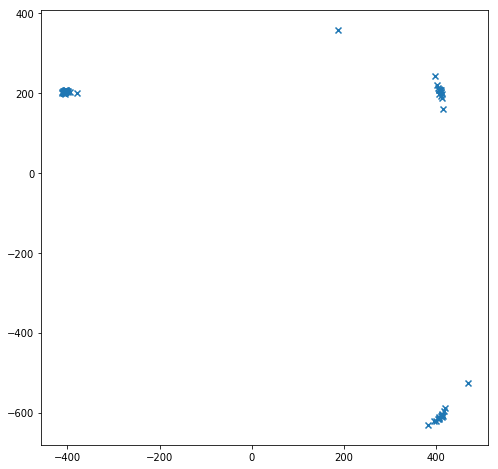

In [103]:
dumper=signaltapCsvDumper(signalTapCsvPath)
dumper.dumpSession(signalPattern=[".*ReceiverTopQsys_0_FFT:fft\|source_real\[(\d+)\]",".*ReceiverTopQsys_0_FFT:fft\|source_imag\[(\d+)\]"],condition="active-high",validPattern=["ReceiverTopQsys_0_FFT:fft|source_valid"],outputName="RXFFTOutput")
with open('./RXFFTOutput.csv') as fp:
    csvBuffer=list(csv.reader(fp))
    data = np.array(csvBuffer,dtype=int)
    real=data[0][::2]
    imag=data[1][::2]
    plt.figure(figsize=(8,8))
    plt.scatter(real,imag,marker='x')
    print(real)
    print(imag)


    demodOut = cs.ConstellationDeMapping(real[1:],imag[1:])
    #Calculate BER
    print(hex(int(demodOut,2)))
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
  

    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)
